# Dueling Deep Q Network

## Imports

In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

## Hyperparameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

#misc agent variables
GAMMA=0.99
LR=1e-4

#memory
TARGET_NET_UPDATE_FREQ = 1000
EXP_REPLAY_SIZE = 100000
BATCH_SIZE = 32

#Learning control variables
LEARN_START = 10000
MAX_FRAMES=700000

#Nstep controls
N_STEPS=1

## Network

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DuelingDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_outputs
        
        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.adv1 = nn.Linear(self.feature_size(), 512)
        self.adv2 = nn.Linear(512, self.num_actions)

        self.val1 = nn.Linear(self.feature_size(), 512)
        self.val2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv)

        val = F.relu(self.val1(x))
        val = self.val2(val)

        return val + adv - adv.mean()
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)
    
    def sample_noise(self):
        #ignore this for now
        pass

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None):
        self.noisy=False
        self.priority_replay=False
        self.sigma_init=0.0
        
        self.gamma=GAMMA
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = BATCH_SIZE
        self.learn_start = LEARN_START

        self.static_policy=static_policy
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n
        self.env = env

        self.declare_networks()
            
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        #move to correct device
        self.model = self.model.to(device)
        self.target_model.to(device)

        if self.static_policy:
            self.model.eval()
            self.target_model.eval()
        else:
            self.model.train()
            self.target_model.train()

        self.update_count = 0

        self.declare_memory()

        self.nsteps = N_STEPS
        self.nstep_buffer = []
    
    def declare_networks(self):
        self.model = DuelingDQN(self.num_feats, self.num_actions)
        self.target_model = DuelingDQN(self.num_feats, self.num_actions)

## Plot Results

In [5]:
def plot(frame_idx, rewards, losses, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Training Loop

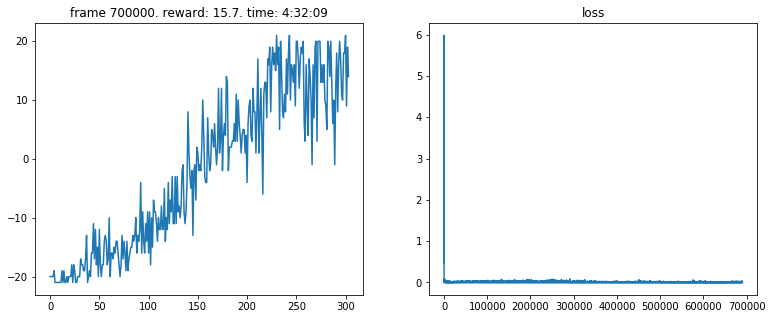

In [6]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=False)
env    = wrap_pytorch(env)
model = Model(env=env)

losses = []
all_rewards = []
episode_reward = 0

observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
    epsilon = epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    loss = model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        observation = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        if np.mean(all_rewards[-10:]) > 19:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))
            break

    if loss is not None:
        losses.append(loss)

    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))


env.close()